This notebook shows how to apply CNN to predict the global temperature map, based on the 1-D time series of CO2 & CH4.

By Weiwei Zhan & Francesco Immorlano

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2023-09-27 22:24:32.715756: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 22:24:32.765710: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

Here we train CNN using simulations from 3 historical and 3 future scenarios. Then we test the trained NN using the ssp245 scenario.

In [3]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [4]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

y_train = y_train_xr['tas'].data
y_test  = y_test_xr['tas'].data



This is how our predictors & predictand data look like. Our predictors are **1-D** time series of CO2 & CH4.

In [5]:
X_train_df.head()

,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


The predictand tas is **2-D** map - this point is different from the NN case

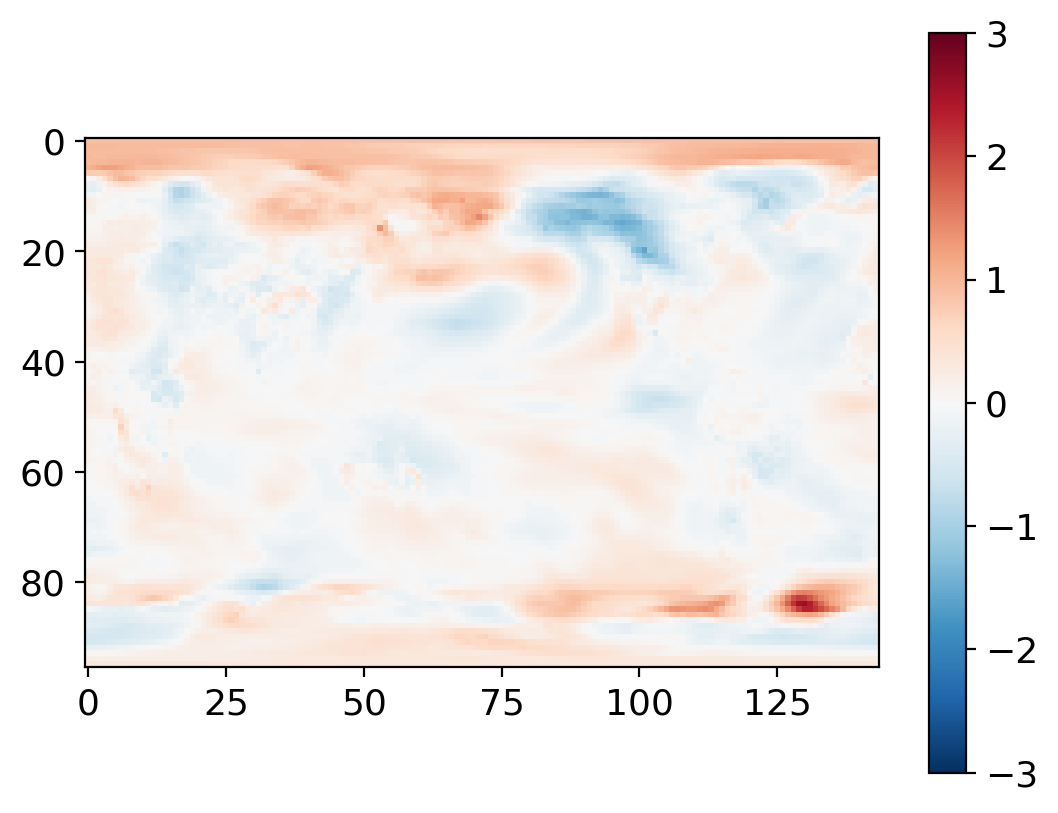

In [6]:
plt.imshow(np.flip(y_train[0],axis=0),cmap='RdBu_r',vmin=-3,vmax=3)
plt.colorbar()

#### Data normalization

Let's normalize the input predictors by there mean & standard deviation

In [7]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

In [8]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(753, 2) (753, 96, 144) (86, 2) (86, 96, 144)


### 2. Define the CNN architecture


The CNN architecture used here consists of several upsampling blocks. 

We set the dimensions of the hidden layers (i.e., number of neurons) in order to reach the size of the target maps (96x144) in a proportional way (in particular by doubling the dimensions in each upsampling block) through the various upsampling blocks. 

![CNN_structure](https://drive.google.com/uc?export=view&id=18a4aKFf62qWgFZP57HloHKrzHdZpmqjO)

Here are the hyperparameters for the CNN training. Note that these hyperparameters here are for demonstration purposes only and they are not optimized.  

In [9]:
n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 4
learning_rate  = 0.001
minibatch_size = 64
num_epochs     = 100


In [10]:
### model using MSE as loss function
model_mse = Sequential()

model_mse.add(Dense(n_filters*12*18, input_shape=(X_train.shape[1],), activation=activation)) # shape: (6912,1)
model_mse.add(Reshape((12,18,n_filters))) # shape: (12,18,32)

# Upsample to 24x36
model_mse.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (24,36,32)

# Upsample to 48x72
model_mse.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (48,72,32)

# Upsample to 96x144
model_mse.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (96,144,32)

model_mse.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation="linear", padding="same")) # shape: (96,144,1)


model_mse.summary()
model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

###-------------------------------------------------------------------------------------------
### model using MAE as loss function
model_mae = Sequential()

model_mae.add(Dense(n_filters*12*18, input_shape=(X_train.shape[1],), activation=activation)) # shape: (6912,1)
model_mae.add(Reshape((12,18,n_filters))) # shape: (12,18,32)

# Upsample to 24x36
model_mae.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (24,36,32)

# Upsample to 48x72
model_mae.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (48,72,32)

# Upsample to 96x144
model_mae.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (96,144,32)

model_mae.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation="linear", padding="same")) # shape: (96,144,1)


model_mae.summary()
model_mae.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6912)              20736     
                                                                 
 reshape (Reshape)           (None, 12, 18, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 24, 36, 32)       16416     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 48, 72, 32)       16416     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 96, 144, 32)      16416     
 ranspose)                                                       
                                                        

### 3. Train & save the CNN model

In [11]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

###------------mse------------
history_mse = model_mse.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

###------------mae------------
history_mae = model_mae.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/100
10/10 [==============================] - 14s 1s/step - loss: 3.6590 - val_loss: 0.5814
Epoch 2/100
10/10 [==============================] - 13s 1s/step - loss: 2.3923 - val_loss: 2.3010
Epoch 3/100
10/10 [==============================] - 11s 1s/step - loss: 1.4355 - val_loss: 0.9340
Epoch 4/100
10/10 [==============================] - 11s 1s/step - loss: 0.8231 - val_loss: 0.6938
Epoch 5/100
10/10 [==============================] - 11s 1s/step - loss: 0.6554 - val_loss: 0.6597
Epoch 6/100
10/10 [==============================] - 11s 1s/step - loss: 0.6055 - val_loss: 0.6502
Epoch 7/100
10/10 [==============================] - 12s 1s/step - loss: 0.5192 - val_loss: 0.6800
Epoch 8/100
10/10 [==============================] - 11s 1s/step - loss: 0.4946 - val_loss: 0.7084
Epoch 9/100
10/10 [==============================] - 11s 1s/step - loss: 0.4690 - val_loss: 0.6886
Epoch 10/100
10/10 [==============================] - 11s 1s/step - loss: 0.4501 - val_loss: 0.6674
Epoch 11/

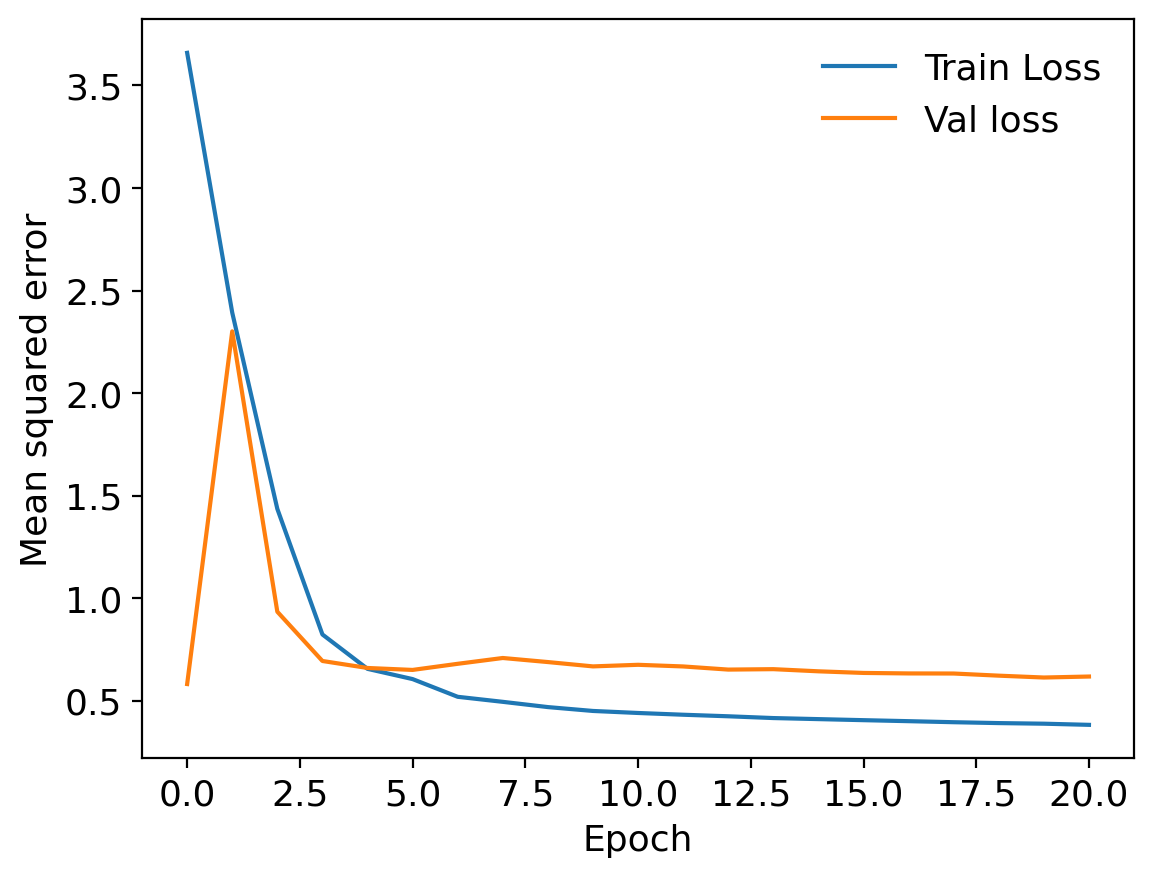

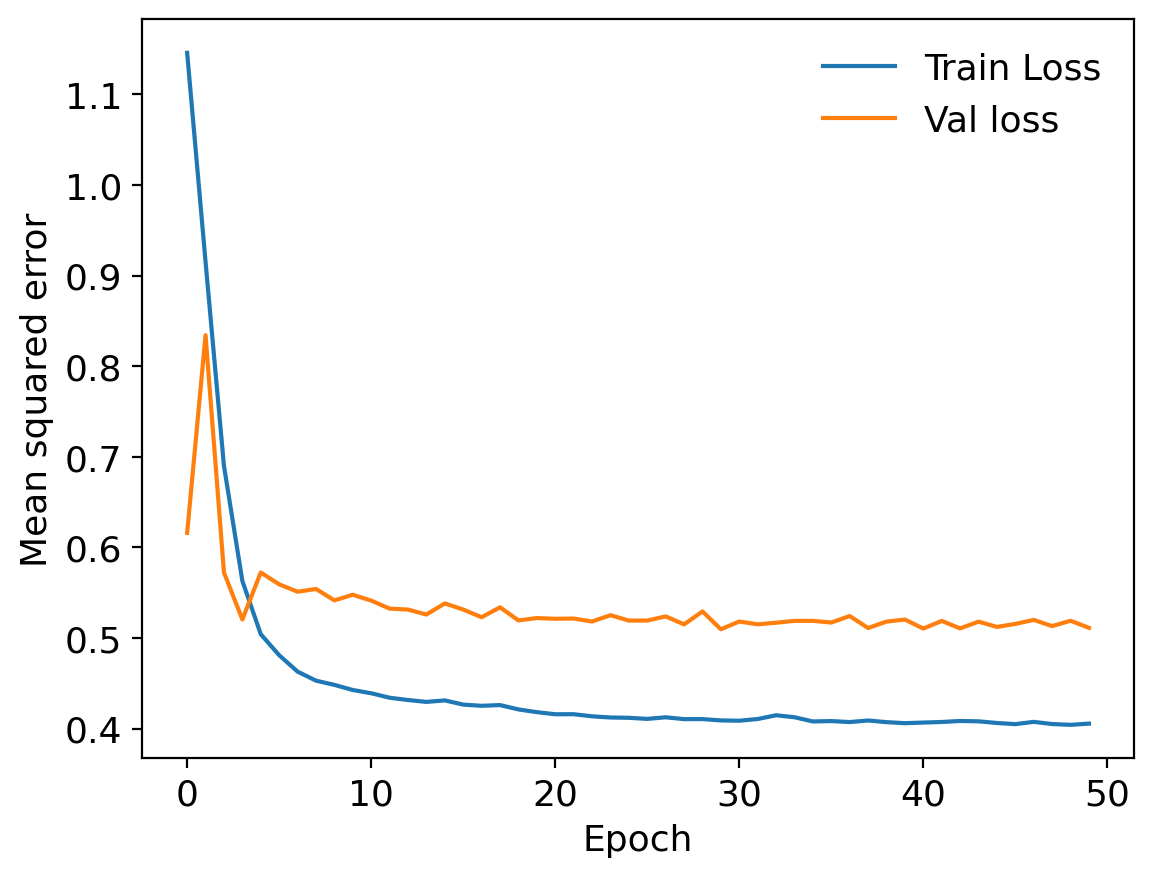

In [12]:
plot_history(history_mse)
plot_history(history_mae)

In [13]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [14]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_mse.save(os.path.join(model_path,'CNN_model_mse.h5'))
model_mae.save(os.path.join(model_path,'CNN_model_mae.h5'))

### 4. Evaluate the trained model

In [15]:
# reload the saved model
model_mse = load_model(os.path.join(model_path,'CNN_model_mse.h5'))
model_mae = load_model(os.path.join(model_path,'CNN_model_mae.h5'))

In [16]:
###------------mse------------
y_test_mse_pre = model_mse.predict(X_test)
y_test_mse_pre = y_test_mse_pre.reshape(y_test_mse_pre.shape[0], 96, 144)
y_test_mse_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_mse_pre)))

###------------mae------------
y_test_mae_pre = model_mae.predict(X_test)
y_test_mae_pre = y_test_mae_pre.reshape(y_test_mae_pre.shape[0], 96, 144)
y_test_mae_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_mae_pre)))



3/3 [==============================] - 1s 199ms/step


First we check whether the ML model can capture the spatial distribution of global temperature

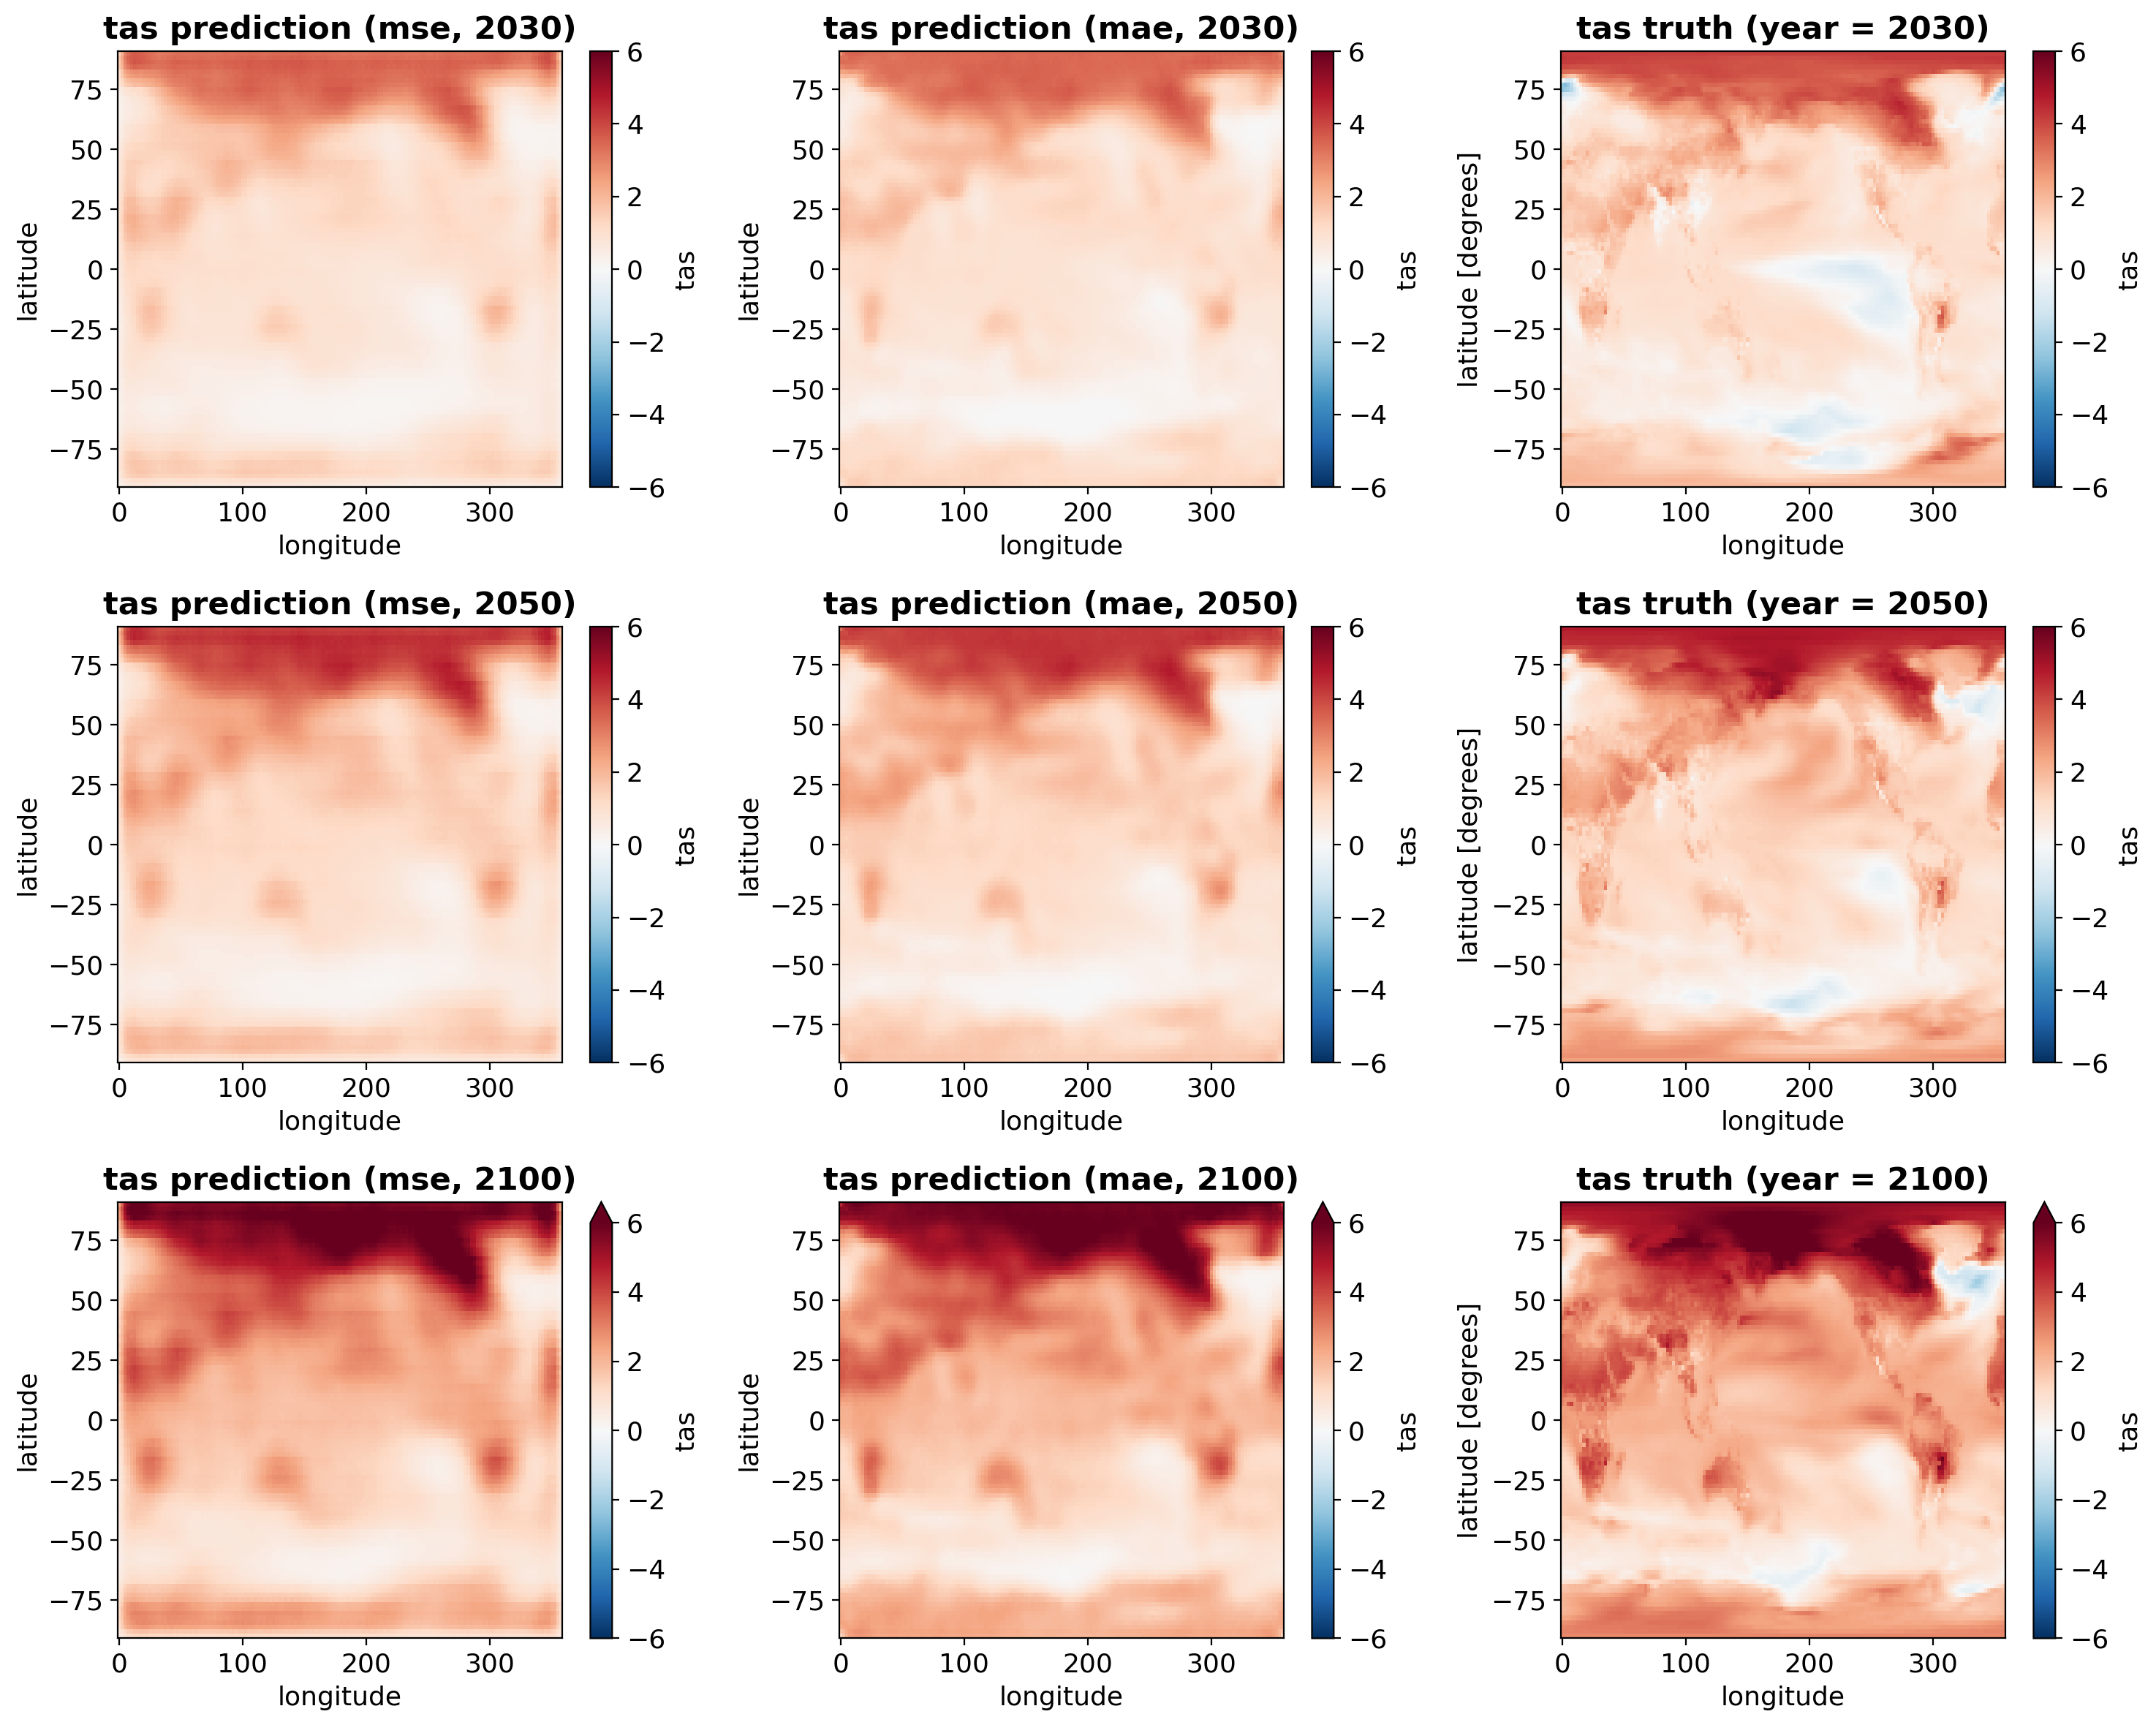

In [17]:
fig, axes = plt.subplots(figsize=(15,12),ncols=3,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_mse_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_mae_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,2], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_mse_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_mae_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,2], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_mse_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_mae_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,2], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 3 == 0:
        ax.set_title(f'tas prediction (mse, {yrs[i//3]})',fontweight='bold')
    # middle column: model prediction
    elif i % 3 == 1:
        ax.set_title(f'tas prediction (mae, {yrs[i//3]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//3]})',fontweight='bold')
plt.tight_layout()

Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

Text(0, 0.5, 'temperature (°C)')

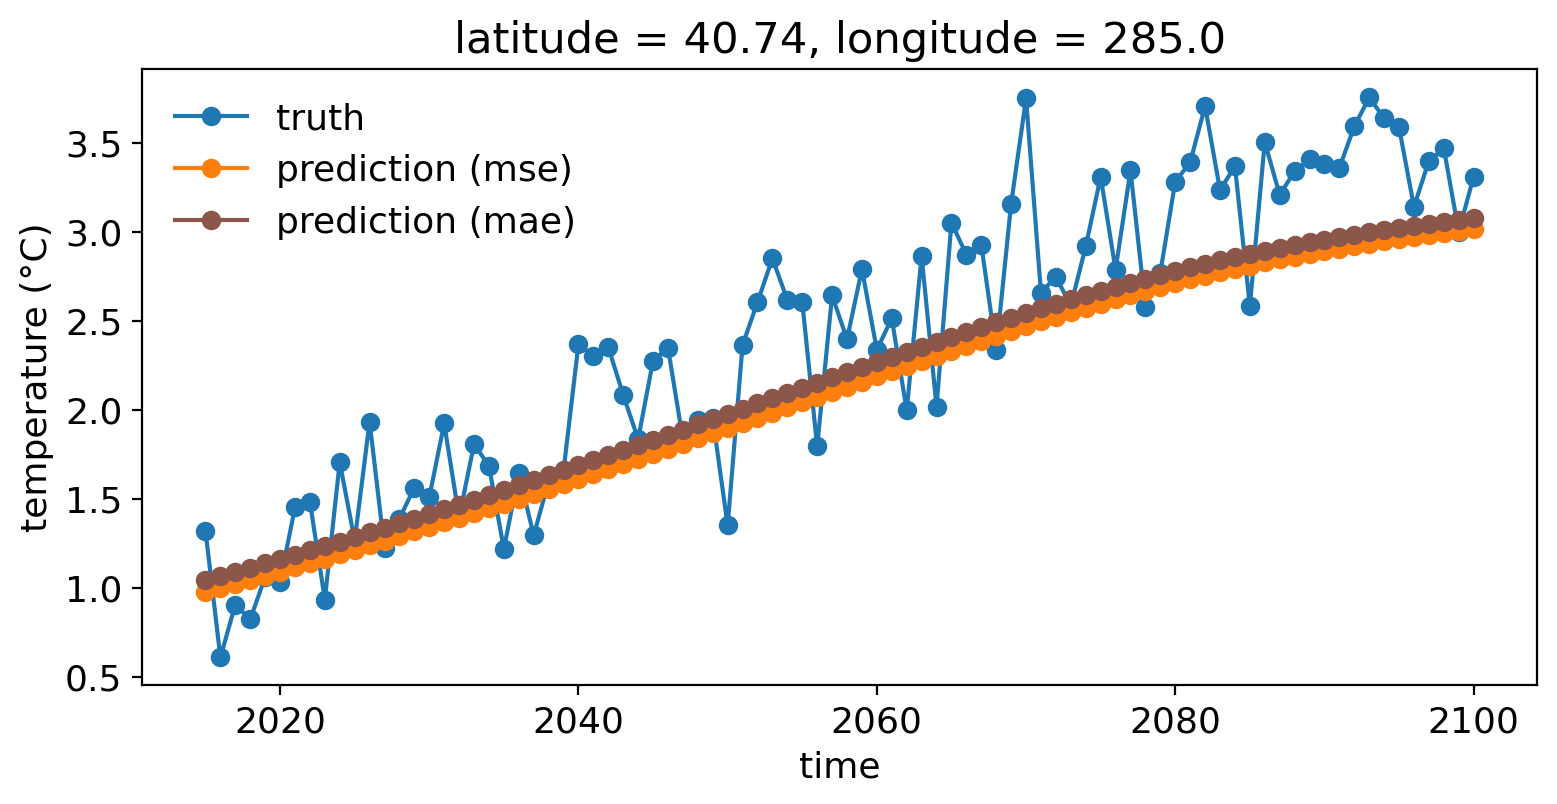

In [18]:
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='truth')
y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='prediction (mse)')
y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:brown',label='prediction (mae)')

ax.legend()
ax.set_ylabel('temperature (°C)')

Let's check the statistical comparison between truth and prediction.

In [19]:
# combine truth and prediction arrays into a dataframe
nyc_test_xr = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.values
nyc_test_mse_pre = y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values
nyc_test_mae_pre = y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values

df_nyc_test = pd.DataFrame()
df_nyc_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_nyc_test["truth"] = nyc_test_xr
df_nyc_test["prediction_mse"] = nyc_test_mse_pre
df_nyc_test["prediction_mae"] = nyc_test_mae_pre
print(df_nyc_test.head(10))

# summary statistics of the dataframe
df_nyc_test.describe()

   time     truth  prediction_mse  prediction_mae
0  2015  1.321960        0.977983        1.045312
1  2016  0.608693        1.000050        1.067880
2  2017  0.905599        1.022454        1.090699
3  2018  0.822795        1.045166        1.113853
4  2019  1.061228        1.068180        1.137253
5  2020  1.035349        1.091413        1.160881
6  2021  1.451701        1.115446        1.185380
7  2022  1.484253        1.139938        1.210081
8  2023  0.934296        1.164697        1.234999
9  2024  1.707011        1.189659        1.260164


,time,truth,prediction_mse,prediction_mae
count,86.000000,86.000000,86.000000,86.000000
mean,2057.500000,2.395548,2.081418,2.154087
std,24.969982,0.836997,0.645939,0.643799
min,2015.000000,0.608693,0.977983,1.045312
25%,2036.250000,1.691455,1.507221,1.583452
50%,2057.500000,2.456390,2.115420,2.197957
75%,2078.750000,3.155296,2.686149,2.754645
max,2100.000000,3.757050,3.016355,3.078883


Finally we check whether the ML model can capture the time series of global average temperature 

In [20]:
def global_mean_std_plot(X,label,color,ax,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tas_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tas_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=color,alpha=0.2)

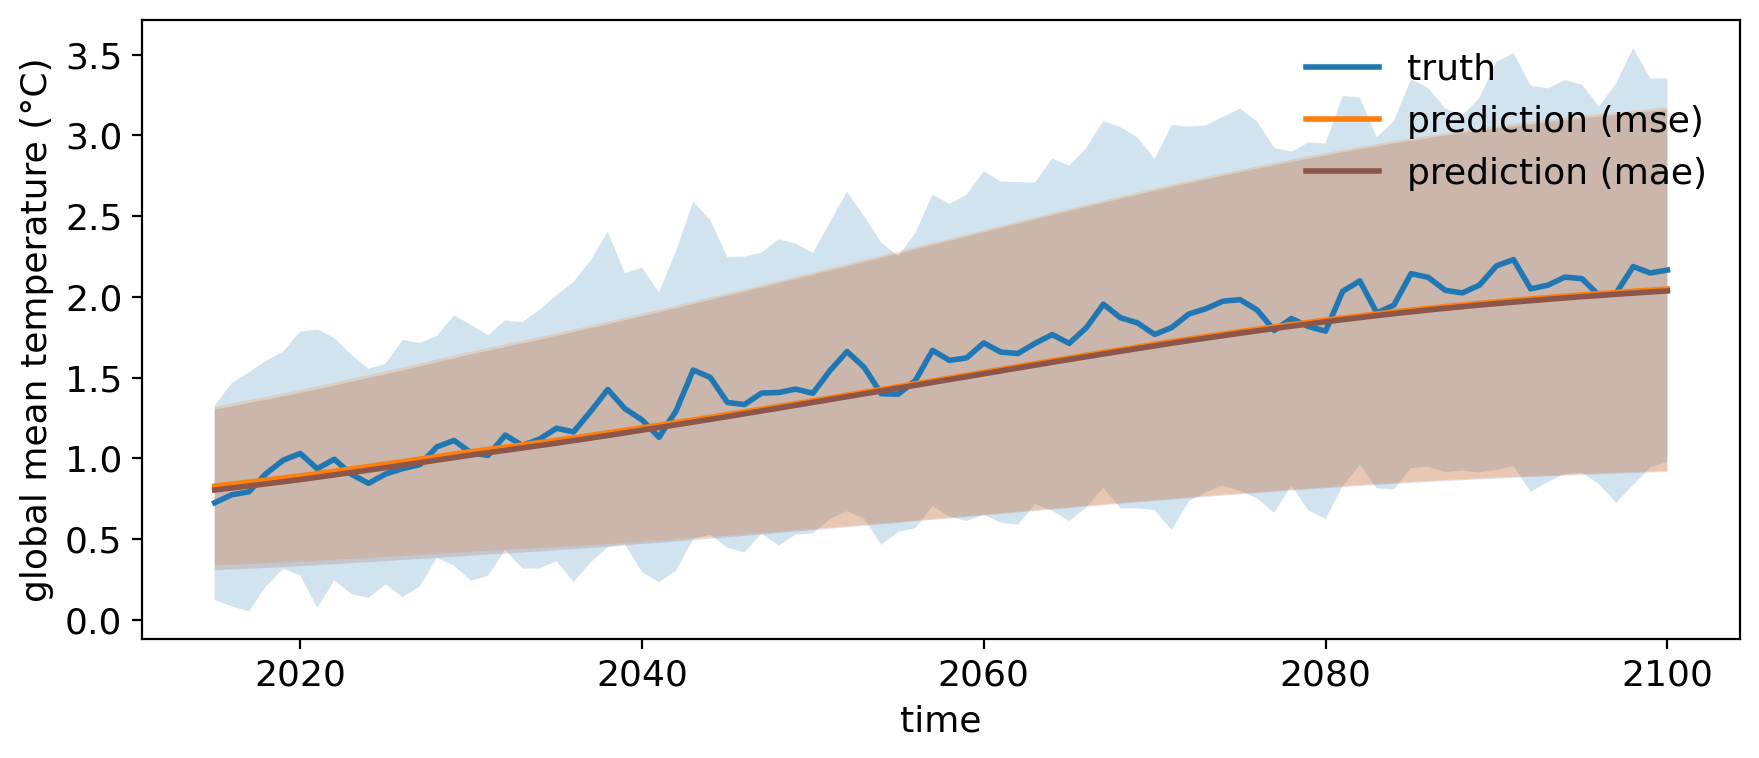

In [21]:
fig,ax = plt.subplots(figsize=(9,4))

global_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_mse_pre,label='prediction (mse)',ax=ax,color='tab:orange')
global_mean_std_plot(y_test_mae_pre,label='prediction (mae)',ax=ax,color='tab:brown')

ax.set_xlabel('time')
ax.set_ylabel('global mean temperature (°C)')
ax.legend()
plt.tight_layout()

In [22]:
# get global mean temperature
def global_mean(X,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X['tas'].weighted(weights).mean(['latitude', 'longitude']).data
    return tas_mean

tas_mean_xr = global_mean(y_test_xr)
tas_mean_mse_pre = global_mean(y_test_mse_pre)
tas_mean_mae_pre = global_mean(y_test_mae_pre)

# put into dataframe
df_globalmean_test = pd.DataFrame()
df_globalmean_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_globalmean_test["truth"] = tas_mean_xr
df_globalmean_test["prediction_mse"] = tas_mean_mse_pre
df_globalmean_test["prediction_mae"] = tas_mean_mae_pre
print(df_globalmean_test.head(10))

# summary statistics of the dataframe
df_globalmean_test.describe()

   time     truth  prediction_mse  prediction_mae
0  2015  0.724876        0.828211        0.803864
1  2016  0.774634        0.840366        0.816282
2  2017  0.792321        0.852764        0.828925
3  2018  0.905029        0.865389        0.841784
4  2019  0.987700        0.878228        0.854880
5  2020  1.030206        0.891278        0.868225
6  2021  0.935918        0.905563        0.882657
7  2022  0.994084        0.920020        0.897269
8  2023  0.900831        0.934631        0.912048
9  2024  0.845252        0.949410        0.926997


,time,truth,prediction_mse,prediction_mae
count,86.000000,86.000000,86.000000,86.000000
mean,2057.500000,1.564246,1.476427,1.462858
std,24.969982,0.430099,0.386945,0.391123
min,2015.000000,0.724876,0.828211,0.803864
25%,2036.250000,1.169074,1.130651,1.113515
50%,2057.500000,1.635698,1.488014,1.478848
75%,2078.750000,1.943204,1.838483,1.828276
max,2100.000000,2.230782,2.047750,2.036473
